# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#imports to help me plot my venn diagrams
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
#from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

# import xgboost as xgb
# import lightgbm as lgb

# import skopt
# from skopt import BayesSearchCV
# class BayesSearchCV(BayesSearchCV):
#     def _run_search(self, x): raise BaseException('Use newer skopt')

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
attributes = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
dias_xls = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [31]:
# Structure of the general population  data

azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6.0,3.0,6.0,6.0,7.0,3.0,5.0,5.0,5.0,4.0,7.0,2.0,3.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2.0,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [32]:
dias_xls.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [33]:
attributes.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [34]:
# data cleaning

dias_xls.drop(columns=['Unnamed: 0'], inplace=True)
dias_xls['Attribute'] = dias_xls['Attribute'].ffill()
dias_xls.head()


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [35]:
# I will now check what is the problem with the columns 19 and 20
# getting the name of these columns
print(azdias.iloc[:,19:21].columns)
print(customers.iloc[:,19:21].columns)


Index(['CAMEO_INTL_2015', 'CJT_GESAMTTYP'], dtype='object')
Index(['CAMEO_INTL_2015', 'CJT_GESAMTTYP'], dtype='object')


In [36]:
attributes.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [37]:
#azdias = special_feature_handler(azdias)
#customers = special_feature_handler(customers)

TypeError: ignored

In [38]:
def is_categorical(array_like):
    return array_like.dtype.name == 'category'

In [39]:
#doing a quick check of categorical features and see if some are too granular to be maintained
#cat_check = categorical_checker(azdias, attributes)

is_categorical(azdias.values)
is_categorical(attributes.values)

False

In [40]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

KeyError: ignored

In [41]:
# checking how the azdias dataframe looks like
print('Printing dataframe shape')
print(azdias.shape)
print('________________________________________________________')

azdias.head()

Printing dataframe shape
(46385, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6.0,3.0,6.0,6.0,7.0,3.0,5.0,5.0,5.0,4.0,7.0,2.0,3.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2.0,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [42]:
# checking how the customer dataframe looks like
print('Printing dataframe shape')
print(customers.shape)
print('________________________________________________________')

customers.head()

Printing dataframe shape
(119640, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1.0,13.0,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,1.0,5.0,1.0,5.0,3.0,1.0,3.0,5.0,1.0,3.0,4.0,7.0,6.0,2.0,1.0,2.0,6.0,1.0,6.0,3.0,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1.0,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,6.0,2.0,3.0,4.0,5.0,6.0,4.0,1.0,2.0,3.0,1.0,7.0,3.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3.0,1.0,4.0
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,7.0,3.0,5.0,1.0,5.0,1.0,5.0,7.0,2.0,6.0,7.0,1.0,7.0,3.0,4.0,2.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2.0,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4.0,24.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,6.0,1.0,3.0,1.0,5.0,2.0,3.0,3.0,5.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,3.0,6.0,4.0,7.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1.0,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1.0,1.0,4.0
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7.0,41.0,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,7.0,1.0,5.0,4.0,3.0,5.0,5.0,4.0,5.0,2.0,3.0,5.0,6.0,6.0,5.0,5.0,4.0,4.0,4.0,5.0,1.0,0.0,3.0,0.0,2.0,4.0,0.0,1.0,2.0,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0


In [43]:
# Check the summary csv file
print(attributes.shape)
attributes.head()

(313, 5)


,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [44]:
#saving the unique attribute names to lists
attributes_list = attributes.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [45]:
#establishing uniqueness of the attributes accross the datasets in work
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of items common to all 3 dataframes: " + str(len(common_to_all)))
print("No of items exclusive to azdias: " + str(len(unique_to_azdias)))
print("No of items exclusive to customers: " + str(len(unique_to_customers)))
print("No of items exclusive to attributes: " + str(len(unique_to_attributes)))
print("No of items overlapping between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of items exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of items exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of items common to all 3 dataframes: 264
No of items exclusive to azdias: 0
No of items exclusive to customers: 0
No of items exclusive to attributes: 49
No of items overlapping between azdias and attributes: 264
No of items exclusive to attributes vs azdias: 49
No of items exclusive to azdias vs attributes: 49


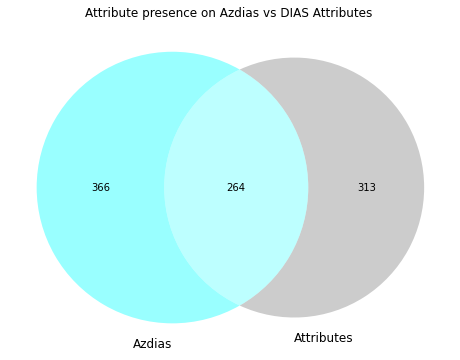

In [46]:
rcParams['figure.figsize'] = 8, 8

ax = plt.axes()
ax.set_facecolor('lightgrey')
v = venn2([len(azdias_list), len(attributes_list), len(common_azdias_attributes)], 
      set_labels=('Azdias', 'Attributes'),
         set_colors = ['cyan', 'grey']);

plt.title("Attribute presence on Azdias vs DIAS Attributes ")
plt.show()

## Preprocessing
After gaining a quick  overview over the data, the next step is to proprocess it. This includes cleaning, handling missing values, prepare features. feature engineering and scaling. 
Missing data is replaced with "NaN". 


In [49]:
azdias_pre_cleanup = azdias.copy()
customers_pre_cleanup = customers.copy()

In [50]:
unknowns_to_NANs(azdias, dias_xls)

In [51]:
unknowns_to_NANs(customers, dias_xls)

In [52]:
balance_checker(azdias, customers)

Feature balance between dfs?:  True


In [53]:
percent_missing_azdias_df = percentage_of_missing(azdias)
percent_missing_azdias_pc_df = percentage_of_missing(azdias_pre_cleanup)

percent_missing_customers_df = percentage_of_missing(customers)
percent_missing_customers_pc_df = percentage_of_missing(customers_pre_cleanup)

In [54]:
print('Identified missing data in Azdias: ')
print('Pre-cleanup: ' + str(azdias_pre_cleanup.isnull().sum().sum()) + 
      ' Post_cleanup: ' + str(azdias.isnull().sum().sum()))

print('Identified missing data in Customers: ')
print('Pre-cleanup: ' + str(customers_pre_cleanup.isnull().sum().sum()) +
      ' Post_cleanup: ' + str(customers.isnull().sum().sum()))

Identified missing data in Azdias: 
Pre-cleanup: 1596452 Post_cleanup: 1785864
Identified missing data in Customers: 
Pre-cleanup: 8673556 Post_cleanup: 9061285


In [55]:
print('Azdias columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_azdias_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_azdias_pc_df['percent_missing'] == 0.0).sum())

print('Customers columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_customers_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_customers_pc_df['percent_missing'] == 0.0).sum())

Azdias columns not missing values(percentage):
Pre-cleanup:  69
Post-cleanup:  71
Customers columns not missing values(percentage):
Pre-cleanup:  69
Post-cleanup:  71


In [56]:
# missing more or less than 30% of the data
azdias_missing_over_30 = split_on_percentage(percent_missing_azdias_df, 30, '>')
azdias_missing_less_30 = split_on_percentage(percent_missing_azdias_df, 30, '<=')

customers_missing_over_30 = split_on_percentage(percent_missing_customers_df, 30, '>')
customers_missing_less_30 = split_on_percentage(percent_missing_customers_df, 30, '<=')

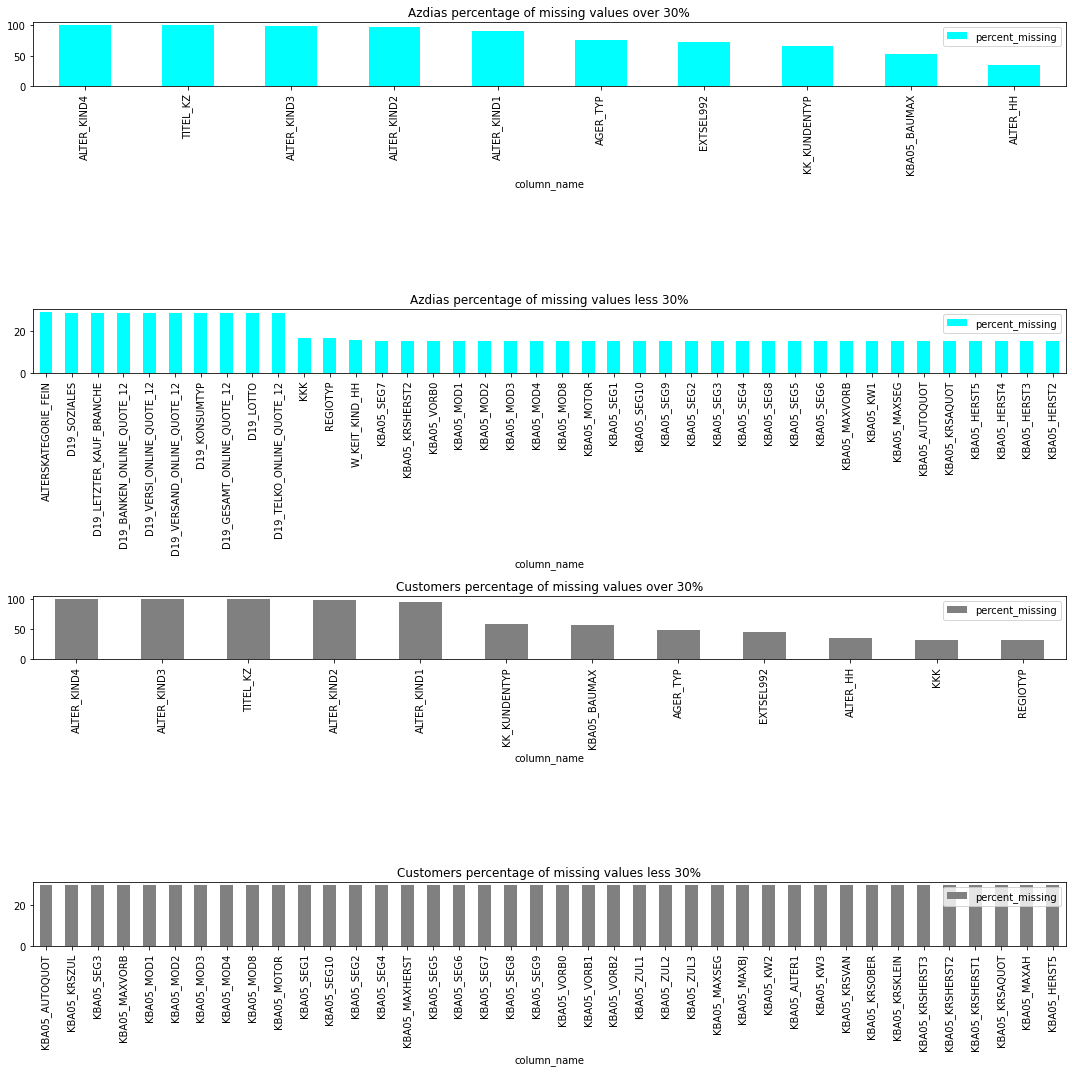

In [57]:
#plotting select features and their missing data percentages
figure, axes = plt.subplots(4, 1, figsize = (15,15), squeeze = False)

azdias_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[0][0], color = 'cyan', title = 'Azdias percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
azdias_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[1][0], color = 'cyan', title = 'Azdias percentage of missing values less 30%' )

customers_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[2][0], color = 'grey', title = 'Customers percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
customers_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[3][0],color = 'grey', title = 'Customers percentage of missing values less 30%' )

plt.tight_layout()
plt.show()

In [58]:
#extracting column names with more than 30% values missing so we can drop them from azdias df
azdias_col_delete = columns_to_delete(azdias_missing_over_30)

#extracting column names with more than 30% values missing so we can drop them from customers df
customers_col_delete = columns_to_delete(customers_missing_over_30)

In [59]:
#dropping the columns identified in the previous lists

azdias = azdias.drop(azdias_col_delete, axis = 1)
customers = customers.drop(customers_col_delete, axis = 1)


In [60]:
#since I just dropped several columns I will do another balance check
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'REGIOTYP', 'KKK'}
Your second argument df differs from the first on the following columns: 
set()


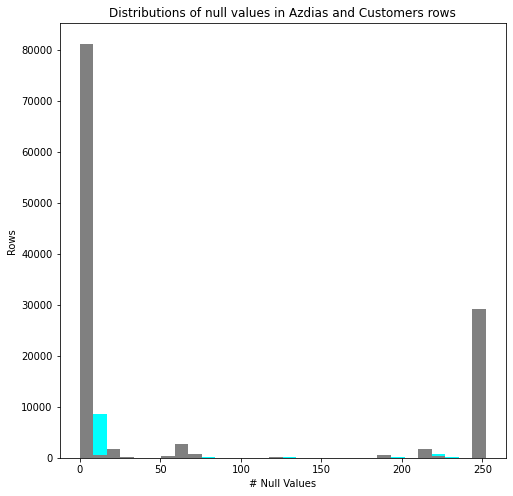

In [61]:

#plotting distribution of null values
row_hist(azdias, customers, 30)

In [65]:
#checking for mixed type features
#attributes[attributes.values.type == 'mixed']

AttributeError: ignored

In [66]:
#retrieve a list of categorical features for future encoding
#cats = attributes[attributes.type == 'categorical']
#list(cats['attribute'])

AttributeError: ignored

In [67]:
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'REGIOTYP', 'KKK'}
Your second argument df differs from the first on the following columns: 
set()


In [68]:
azdias_eng = azdias.copy()
customers_eng = customers.copy()
azdias_eng = feat_eng(azdias_eng)
customers_eng = feat_eng(customers_eng)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


In [69]:
#dataframes using StandardScaler
azdias_SS = feature_scaling(azdias_eng, 'StandardScaler')
customers_SS = feature_scaling(customers_eng, 'StandardScaler')

In [70]:
#dataframes using MinMaxScaler
azdias_MMS = feature_scaling(azdias_eng, 'MinMaxScaler')
customers_MMS = feature_scaling(customers_eng, 'MinMaxScaler')

In [71]:
# dimensionality reduction
# pca
n_components_azdias = len(azdias_SS.columns.values)
n_components_customers = len(customers_SS.columns.values)

azdias_SS_pca = pca_model(azdias_SS, n_components_azdias)
customers_SS_pca = pca_model(customers_SS, n_components_customers)

azdias_MMS_pca = pca_model(azdias_MMS, n_components_azdias)
customers_MMS_pca = pca_model(customers_MMS, n_components_customers)

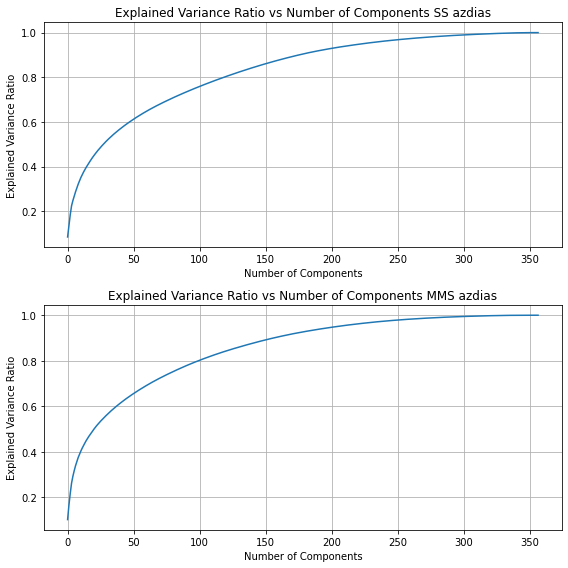

In [72]:
scree_plots(azdias_SS_pca, azdias_MMS_pca, ' azdias')

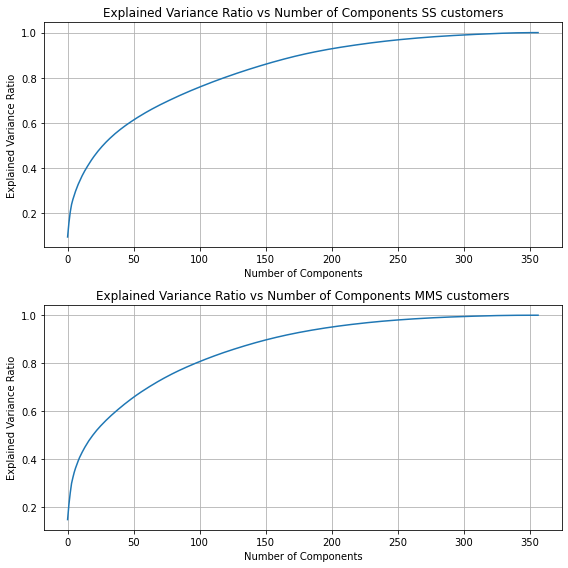

In [73]:
scree_plots(customers_SS_pca, customers_MMS_pca, ' customers')

In [74]:
display_interesting_features(azdias_SS, azdias_SS_pca, 0)

Lowest: 
	CAMEO_DEUG_2015      -0.125
	CAMEO_DEU_2015       -0.124
	KBA13_ANTG3          -0.124
Highest: 
	KBA13_ANTG1          0.124
	MOBI_RASTER          0.125
	PLZ8_ANTG1           0.125


In [75]:
display_interesting_features(azdias_SS, azdias_SS_pca, 1)

Lowest: 
	D19_GESAMT_ONLINE_DATUM -0.142
	D19_GESAMT_DATUM     -0.138
	D19_VERSAND_ONLINE_DATUM -0.137
Highest: 
	D19_GESAMT_ANZ_12    0.138
	ONLINE_AFFINITAET    0.141
	D19_GESAMT_ANZ_24    0.146


In [76]:
display_interesting_features(azdias_SS, azdias_SS_pca, 3)

Lowest: 
	PRAEGENDE_JUGENDJAHRE_DECADE -0.192
	FINANZ_SPARER        -0.187
	FINANZ_UNAUFFAELLIGER -0.186
Highest: 
	LP_LEBENSPHASE_FEIN_life_stage 0.147
	ALTERSKATEGORIE_GROB 0.158
	FINANZ_VORSORGER     0.165


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [77]:
pca = PCA(150)
azdias_SS_pca = pca.fit_transform(azdias_SS)
customers_SS_PCA = pca.fit_transform(customers_SS)

In [78]:

# refitting using just 9 clusters
kmeans = KMeans(9)
kmodel = kmeans.fit(azdias_SS_pca)

In [79]:
#and now we can compare the customer data to the general demographics
azdias_clusters = kmodel.predict(pca.transform(azdias_SS))
customers_clusters = kmodel.predict(pca.transform(customers_SS))

In [80]:
#getting clusters for the LNRs for the customers
cluster_map = pd.DataFrame()
cluster_map['LNR'] = azdias_eng.index.values
cluster_map['cluster'] = kmodel.labels_

In [81]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

NameError: ignored

In [82]:
#transform the customers using pca
customers_pca = pca.transform(customers_SS)

#predict clustering using the kmeans
predict_customers = kmodel.predict(customers_pca)

#cluster and center prediction and info
clust_preds = kmodel.predict(azdias_SS_pca)
centers = kmodel.cluster_centers_

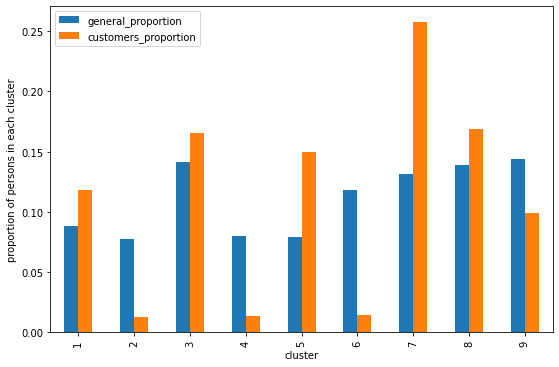

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(9)]
for i in range(9):
    general_pop.append((clust_preds == i).sum()/len(clust_preds))
    customers_pop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [85]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
#running all the cleaning and feature transformation functions
#fixing the mixed type columns
mailout_train = special_feature_handler(mailout_train)
mailout_test = special_feature_handler(mailout_test)

#dealing with missing and unknowns
unknowns_to_NANs(mailout_train, dias_xls)
unknowns_to_NANs(mailout_test, dias_xls)

#getting percentages of missing
percent_missing_train = percentage_of_missing(mailout_train)
percent_missing_test = percentage_of_missing(mailout_test)

#getting missing over 30%
train_missing_over_30 = split_on_percentage(percent_missing_train, 30, '>')
test_missing_over_30 = split_on_percentage(percent_missing_test, 30, '>')

#getting columns to delete
train_col_delete = columns_to_delete(train_missing_over_30)
test_col_delete = columns_to_delete(test_missing_over_30)

#dropping cols
mailout_train = mailout_train.drop(train_col_delete, axis = 1)
mailout_test = mailout_test.drop(test_col_delete, axis = 1)

#feature engineering
mailout_train = feat_eng(mailout_train)
mailout_test = feat_eng(mailout_test)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


In [87]:
balance_checker(azdias_eng, mailout_train)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
set()
Your second argument df differs from the first on the following columns: 
{'RESPONSE'}


In [88]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'RESPONSE'}
Your second argument df differs from the first on the following columns: 
set()


In [89]:
#merging mailout and cluster map on the LNR column
clusters_mailout = pd.merge(mailout_train, cluster_map, on = 'LNR')
response_and_cluster = clusters_mailout[['LNR', 'RESPONSE', 'cluster']]

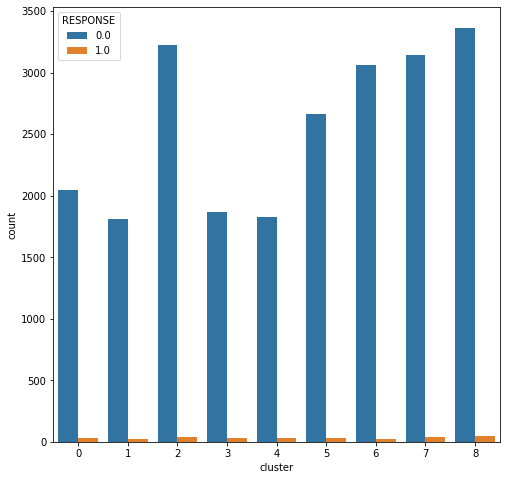

In [90]:

ax = sns.countplot(x="cluster", hue="RESPONSE", data=response_and_cluster)

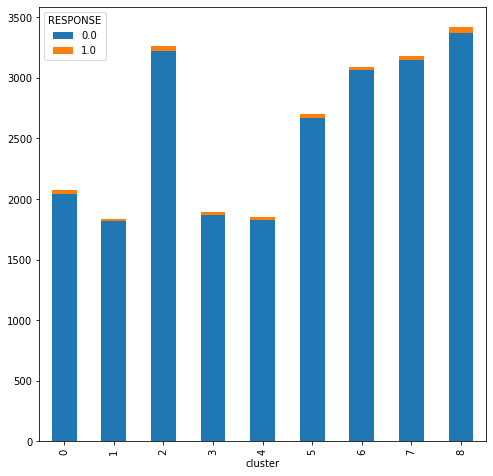

In [91]:
plot1 = response_and_cluster.groupby(['cluster', 'RESPONSE'])['RESPONSE'].count().unstack('RESPONSE')
plot1[[0, 1]].plot(kind = 'bar', stacked = True)

In [92]:
df_pos_response = response_and_cluster[response_and_cluster['RESPONSE'] == 1]
df_neg_response = response_and_cluster[response_and_cluster['RESPONSE'] == 0]

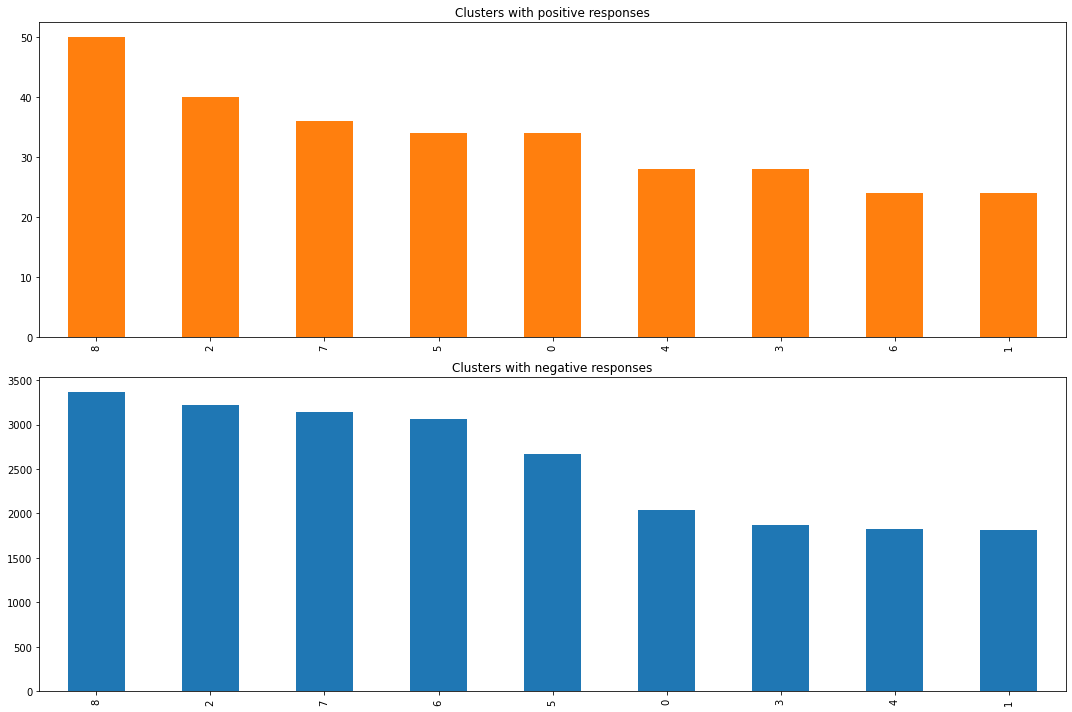

In [93]:
figure, axes = plt.subplots(2, 1, figsize = (15,15), squeeze = False)

pos = df_pos_response['cluster'].value_counts().plot(kind='bar',figsize=(15,10), color = 'C1', ax = axes[0][0], title = 'Clusters with positive responses')
neg = df_neg_response['cluster'].value_counts().plot(kind='bar',figsize=(15,10), ax = axes[1][0], title = 'Clusters with negative responses')

plt.tight_layout()
plt.show()

In [94]:
#getting the target
target = mailout_train['RESPONSE']
mailout_train_clean = mailout_train.drop(['RESPONSE'], inplace=False, axis=1)

In [95]:
#dropping LNR
mailout_test_clean = mailout_test.copy()
mailout_train_clean.drop(['LNR'], inplace = True, axis = 1)
mailout_test_clean.drop(['LNR'], inplace = True, axis = 1)

In [96]:
balance_checker(mailout_train_clean, mailout_test_clean)

Feature balance between dfs?:  True


Text(0.5, 1.0, 'Label distribution')

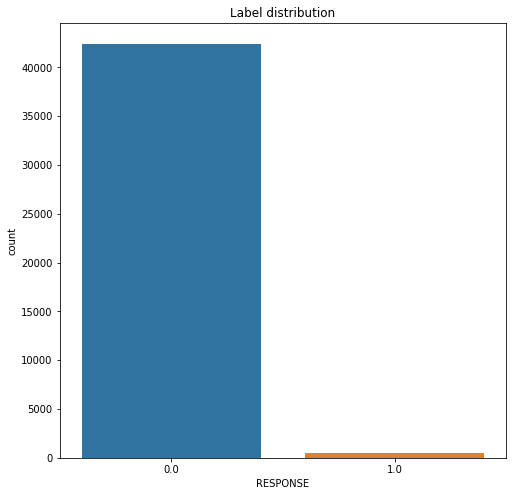

In [97]:
#checking the label distribution

sns.countplot(target).set_title("Label distribution")

In [98]:
SEED = 28

In [99]:
# 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf.get_n_splits(mailout_train_clean, target)

5

In [100]:
scaler = MinMaxScaler()
scaler.fit(mailout_train_clean.astype('float'))

mailout_train_scaled = scaler.transform(mailout_train_clean)
mailout_test_scaled = scaler.transform(mailout_test_clean)

# map back to dfs
mailout_train_scaled = pd.DataFrame(data=mailout_train_scaled, columns=mailout_train_clean.columns)
mailout_test_scaled = pd.DataFrame(data=mailout_test_scaled, columns=mailout_test_clean.columns)

In [101]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'RESPONSE'}
Your second argument df differs from the first on the following columns: 
set()


In [102]:
#submission 1 parameters
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.6872852588903648, 
                              eval_metric='auc', 
                              gamma=1.0,
                              learning_rate=0.014017007043823785, 
                              max_delta_step=0, 
                              max_depth=7,
                              min_child_weight=1, 
                              missing=None, 
                              n_estimators=236, 
                              n_jobs=-1,
                              nthread=None, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.5)

NameError: ignored

In [103]:

bayes_xgb.fit(mailout_train_scaled, target)

NameError: ignored

In [104]:
plot_feature_importances(model=bayes_xgb, model_type="XGBClassifier", features=mailout_train_scaled.columns)

NameError: ignored

In [105]:
#submission 2 lgbm
bayes_lgbm = lgb.LGBMClassifier(application='binary', 
                                boosting_type='gbdt', 
                                class_weight=None,
                                colsample_bytree=1.0, 
                                importance_type='split',
                                learning_rate=0.0882410095694084, 
                                max_bin=826, 
                                max_depth=2,
                                metric='auc', 
                                min_child_samples=0, 
                                min_child_weight=0.001,
                                min_data_in_leaf=32, 
                                min_split_gain=0.0, 
                                n_estimators=24,
                                n_jobs=-1, 
                                num_leaves=94, 
                                objective=None, 
                                random_state=None,
                                reg_alpha=1.0, 
                                reg_lambda=1e-09,
                                scale_pos_weight=90.0, 
                                silent=True, 
                                subsample=1.0,
                                subsample_for_bin=200000, 
                                subsample_freq=0, 
                                verbose=0)

NameError: ignored

In [106]:
bayes_lgbm.fit(mailout_train_scaled, target)

NameError: ignored

In [107]:
plot_feature_importances(model=bayes_lgbm, model_type="LGBMClassifier", features=mailout_train_scaled.columns)

NameError: ignored

In [108]:
plot_comparison_feature(column = 'D19_SOZIALES', df=mailout_train)

NameError: ignored

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [109]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

FileNotFoundError: ignored

In [110]:
#fit and predict xgb
bayes_xgb.fit(mailout_train_scaled, target)
predictions = bayes_xgb.predict_proba(mailout_test_scaled)[:,1]

NameError: ignored

In [111]:
#fit and predict lgbm
bayes_lgbm.fit(mailout_train_scaled, target)
predictions = bayes_lgbm.predict_proba(mailout_test_scaled)[:,1]

NameError: ignored

In [112]:
# create submission file
lnr = pd.DataFrame(mailout_test['LNR'].astype('int32'))
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: "RESPONSE"})
dfs = [lnr, predictions]
submission = pd.concat(dfs, sort=False, axis=1)
submission.set_index('LNR', inplace = True)
submission.head()

NameError: ignored

In [113]:
submission.shape

NameError: ignored

In [ ]:
submission.to_csv('kaggle_sub10.csv')